In [1]:
import lime
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from wordcloud   import WordCloud
from lime.lime_text import LimeTextExplainer

from matplotlib  import cm
from keras.utils import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Input
from keras.models import Model
from keras.callbacks   import ModelCheckpoint, EarlyStopping
from sklearn.metrics   import roc_curve, auc, confusion_matrix
from sklearn.metrics   import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras  import backend as K
from matplotlib.colors import Normalize, Colormap, LinearSegmentedColormap
from sklearn.model_selection  import train_test_split
from keras.preprocessing.text import Tokenizer

2023-12-04 23:30:04.481707: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-04 23:30:04.502508: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-04 23:30:04.558341: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 23:30:04.558381: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 23:30:04.558416: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

## Input tokenized and padded

In [2]:
# Load your data
# sData = pd.read_csv('/content/drive/MyDrive/clean_data.csv')
df = pd.read_csv('clean_data.csv')

sentences = df['headline'].tolist()
labels = df['is_sarcastic'].tolist()

# Split the data into training and test sets
sentences_train, sentences_test, labels_train, labels_test = train_test_split(sentences, 
                                                                              labels, 
                                                                              test_size=0.2, 
                                                                              random_state=2456)

# Tokenization and padding
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(sentences_train)
word_index = tokenizer.word_index
# print(word_index)

# Define a fixed sequence length
max_sequence_length_train = 30

# Pad sequences for both training and test sets
seq_train = tokenizer.texts_to_sequences(sentences_train)
seq_test  = tokenizer.texts_to_sequences(sentences_test)
# print(seq_test)
# print("---")

padded_seq_train = pad_sequences(seq_train, padding="post",
                                 maxlen=max_sequence_length_train)
padded_seq_test  = pad_sequences(seq_test, padding="post",
                                 maxlen=max_sequence_length_train)
# print(padded_seq_test)
# print("---")

# Convert labels to numpy arrays for both training and test sets
labels_train = np.array(labels_train)
labels_test  = np.array(labels_test)

# print(labels_test)

In [3]:
lemmatizer = nltk.wordnet.WordNetLemmatizer()
lemma = lemmatizer.lemmatize

# generate wordclouds
group_list = df.is_sarcastic.unique()
cloud_list = []

colors = ["#7CCDFF","#01D38E","#EC4C36","#35A2A1","#FFBD0B"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)

for idx, i in enumerate(group_list):
    text   = ' '.join(df.headline[df.is_sarcastic.isin([i])])
    tokens = nltk.word_tokenize(text)
    lemmatized = [lemma(token) for token in tokens]
    lemmatized = ' '.join(lemmatized)
    
    wordcloud = WordCloud(max_font_size=160, max_words=70,
                          width=1600, height=800,
                          scale=3, colormap=cmap,
                          min_font_size=10,
                          min_word_length=3,
                          normalize_plurals=True,
                          stopwords=stopwords.words('english'),
                          background_color="white").generate(lemmatized)
    cloud_list.append(wordcloud)

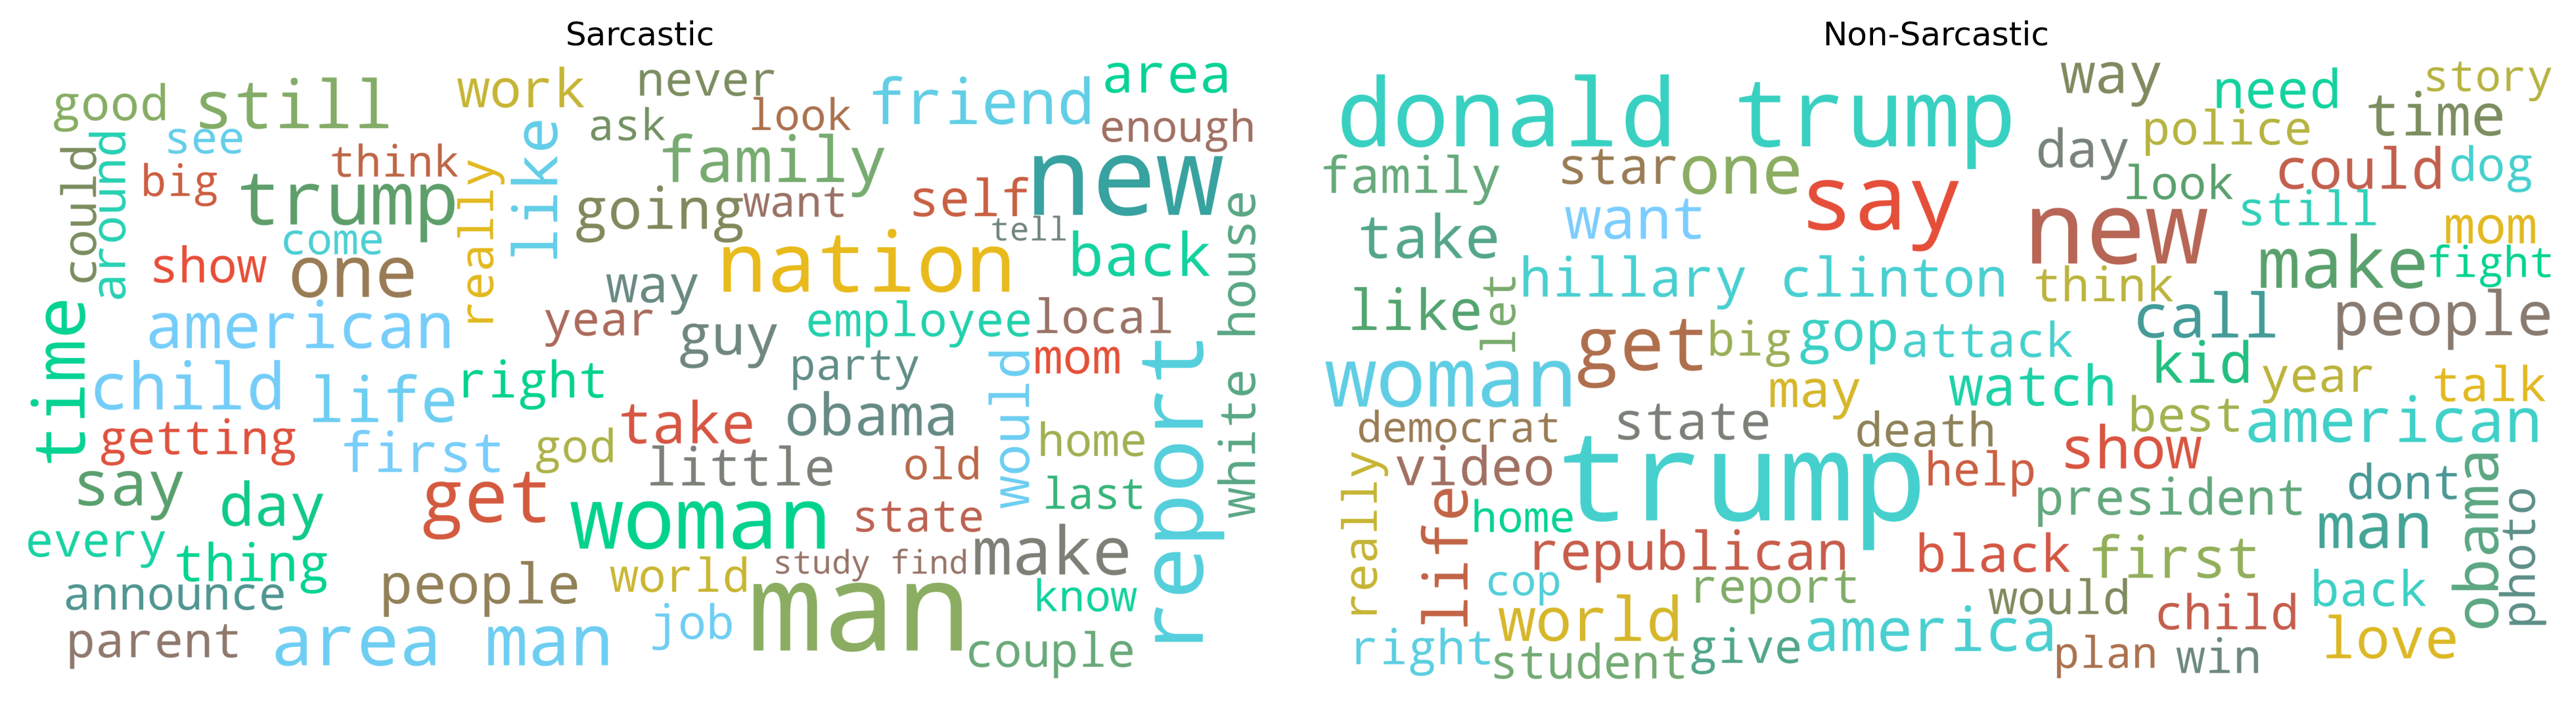

In [4]:
# plotting
fig = plt.figure(figsize=(20, 16), dpi=300)
plt.subplots_adjust(hspace=0.5)
for idx, cloud in enumerate(cloud_list):
    ax = plt.subplot(4, 3, idx+1)
    ax.imshow(cloud, interpolation="bilinear")
    ax.set_axis_off()
    ax.set_title("Sarcastic" if idx == 0 else "Non-Sarcastic" )

plt.tight_layout(pad=2.)
plt.show()

## Baseline: Logistic Regression

**something something better with epoch**

In [5]:
# history_1 = lg_model.fit(padded_seq_train, labels_train,
#                          epochs = 5,
#                          validation_data = (padded_seq_test, labels_test))

## Model: LSTM + Attention

In [6]:
class AttentionLayers(tf.keras.layers.Layer):
    def __init__(self, return_attention=False, **kwargs):
        super(AttentionLayers, self).__init__(**kwargs)
        self.return_attention = return_attention

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        super(AttentionLayers, self).build(input_shape)

    def call(self, x):
        et = tf.keras.backend.squeeze(tf.keras.backend.dot(x, self.W), axis=-1)
        at = tf.keras.backend.exp(et)
        at_sum = tf.keras.backend.sum(at, axis=1, keepdims=True)
        at = at / at_sum
        at = tf.keras.backend.expand_dims(at, axis=-1)
        output = x * at
        if self.return_attention:
            return [tf.keras.backend.sum(output, axis=1), at]
        else:
            return tf.keras.backend.sum(output, axis=1)


# Define the model with attention mechanism
input_layer = Input(shape=(max_sequence_length_train,))
embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=64,
                            input_length=max_sequence_length_train)(input_layer)
lstm_layer = LSTM(64, return_sequences=True)(embedding_layer)
attention_output, attention_weights = AttentionLayers(return_attention=True)(lstm_layer)
output_layer = Dense(1, activation='sigmoid')(attention_output)
attention_model = Model(inputs=input_layer, outputs=[output_layer, attention_weights])

# Compile and train the model with attention mechanism
attention_model.compile(loss='binary_crossentropy', optimizer='adam',
                        metrics=['accuracy'])
attention_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 64)            1454784   
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 attention_layers (Attentio  [(None, 64),              64        
 nLayers)                     (None, 30, 1)]                     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1487937 (5.68 MB)
Trainable params: 1487937 (5.68 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________

In [7]:
history_2 = attention_model.fit(padded_seq_train, labels_train,
                                epochs = 5,
                                validation_data = (padded_seq_test, labels_test))

Epoch 1/5
611/611 [==============================] - 17s 24ms/step - loss: 2.0632 - dense_loss: 0.4156 - attention_layers_loss: 1.6475 - dense_accuracy: 0.8025 - attention_layers_accuracy: 0.5208 - val_loss: 1.9888 - val_dense_loss: 0.3520 - val_attention_layers_loss: 1.6368 - val_dense_accuracy: 0.8511 - val_attention_layers_accuracy: 0.5241
Epoch 2/5
611/611 [==============================] - 14s 23ms/step - loss: 1.8497 - dense_loss: 0.2021 - attention_layers_loss: 1.6475 - dense_accuracy: 0.9225 - attention_layers_accuracy: 0.5208 - val_loss: 2.0007 - val_dense_loss: 0.3641 - val_attention_layers_loss: 1.6365 - val_dense_accuracy: 0.8448 - val_attention_layers_accuracy: 0.5241
Epoch 3/5
611/611 [==============================] - 14s 23ms/step - loss: 1.7589 - dense_loss: 0.1114 - attention_layers_loss: 1.6475 - dense_accuracy: 0.9620 - attention_layers_accuracy: 0.5208 - val_loss: 2.0813 - val_dense_loss: 0.4447 - val_attention_layers_loss: 1.6366 - val_dense_accuracy: 0.8368 - val

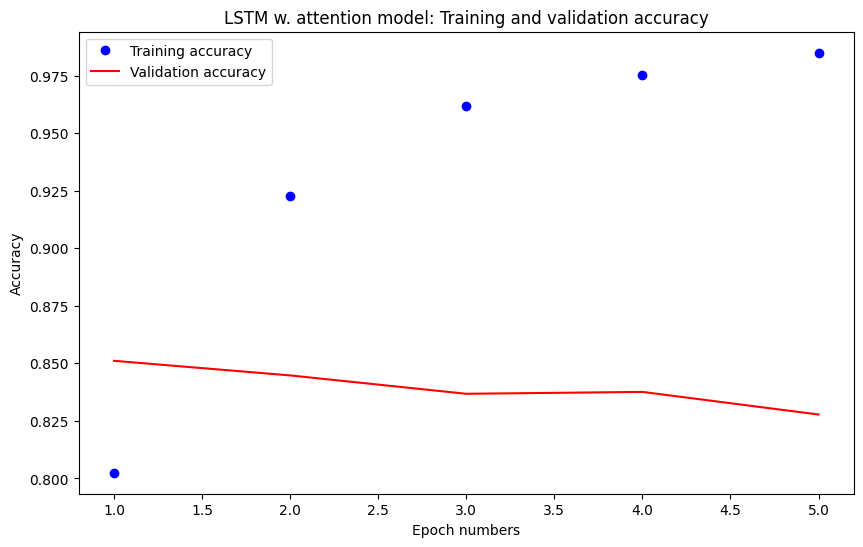

In [8]:
plt.figure(figsize=(10, 6), dpi=100)
acc = history_2.history['dense_accuracy']
val_acc = history_2.history['val_dense_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.legend()
plt.xlabel("Epoch numbers")
plt.ylabel("Accuracy")
plt.title('LSTM w. attention model: Training and validation accuracy')
plt.savefig('LSTM_ATT_acc_plot.png')
plt.show()

 68/153 [============>.................] - ETA: 0s

153/153 [==============================] - 1s 7ms/step


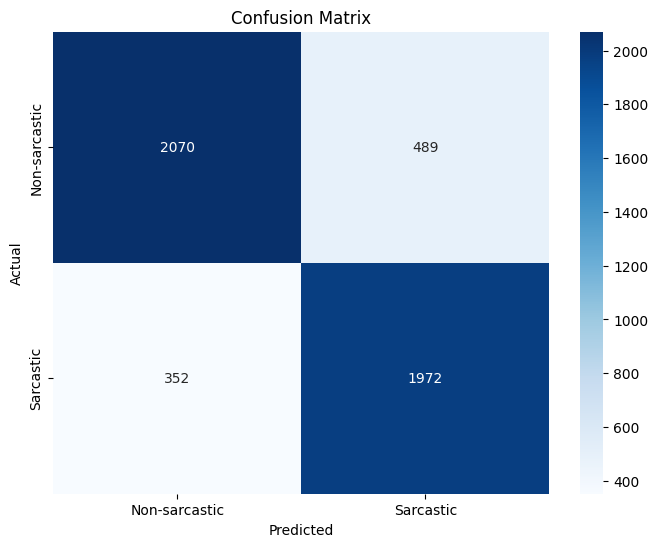

In [9]:
prob   = attention_model.predict(padded_seq_test)[0]
y_pred = (prob > 0.5).astype("int32")

cm = confusion_matrix(labels_test, y_pred)

# Plotting
plt.figure(figsize=(8, 6), dpi=100)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-sarcastic', 'Sarcastic'],
            yticklabels=['Non-sarcastic', 'Sarcastic'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 24ms/step


[[0.9940834]]


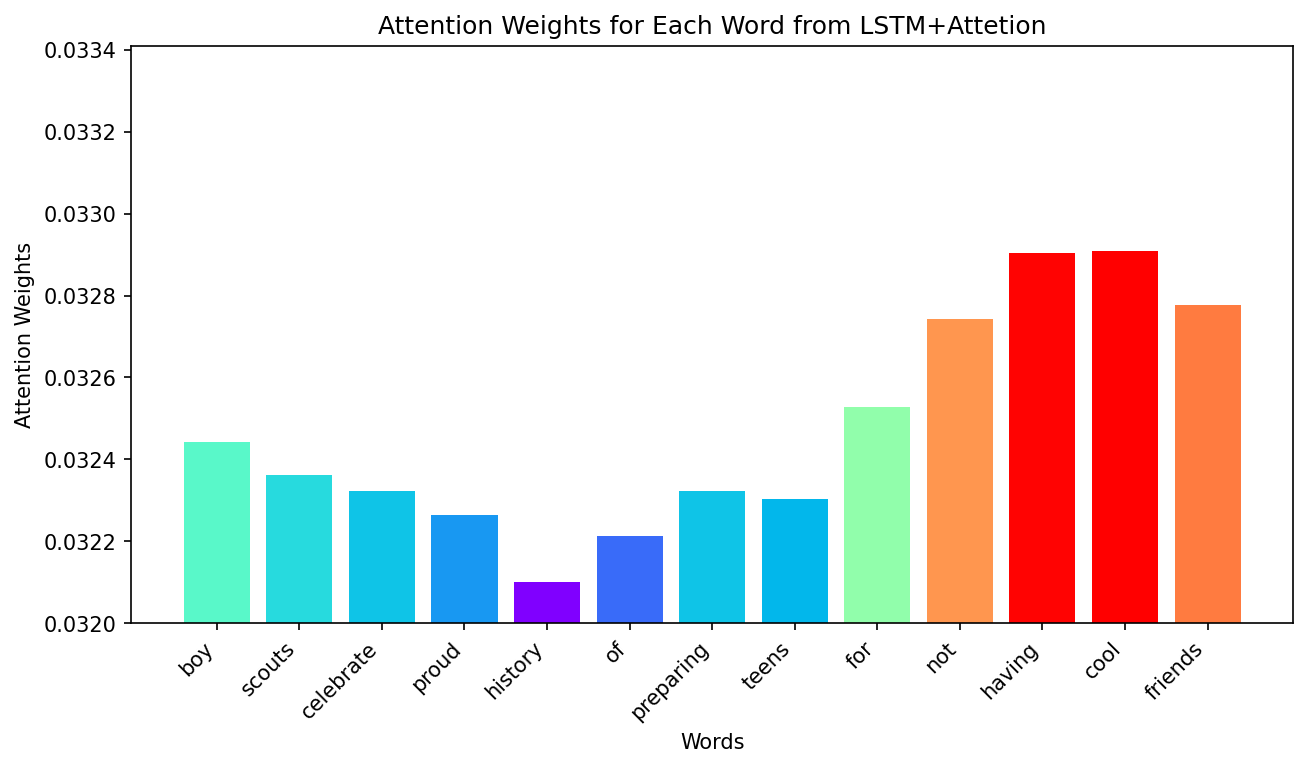

In [10]:
# import again avoiding error
from matplotlib  import cm

def visualize_attention_weights(sentence, model, tokenizer):
    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, padding="post",
                                    maxlen=max_sequence_length_train)

    # get the attention weights
    prediction, attention_weights = model.predict(padded_sequence)
    print(prediction)
    
    # handle the example
    words = sentence.split()
    num_words = len(words)

    # trim the length
    attention_weights = attention_weights[0, :num_words].reshape(-1)
    
    # normalize the attention weights to range [0, 1] for color mapping
    attention_weights_log = np.log(attention_weights + 1e-5)  
    normalized_weights_log = (attention_weights_log - np.min(attention_weights_log)) / (np.max(attention_weights_log) - np.min(attention_weights_log))
    cols = cm.rainbow(normalized_weights_log)

    # plot
    plt.figure(figsize=(10, 5),dpi=150)
    plt.bar(np.arange(num_words), attention_weights, color=cols)
    plt.xticks(np.arange(num_words), words, rotation=45, ha='right')
    plt.xlabel('Words')
    plt.ylabel('Attention Weights')
    plt.ylim(0.032, max(attention_weights) + 0.0005)
    plt.title('Attention Weights for Each Word from LSTM+Attetion')
    plt.show()

example_1 = "boy scouts celebrate proud history of preparing teens for not having cool friends"
visualize_attention_weights(example_1, attention_model, tokenizer)

1/1 [==============================] - 0s 23ms/step


[[0.04348431]]


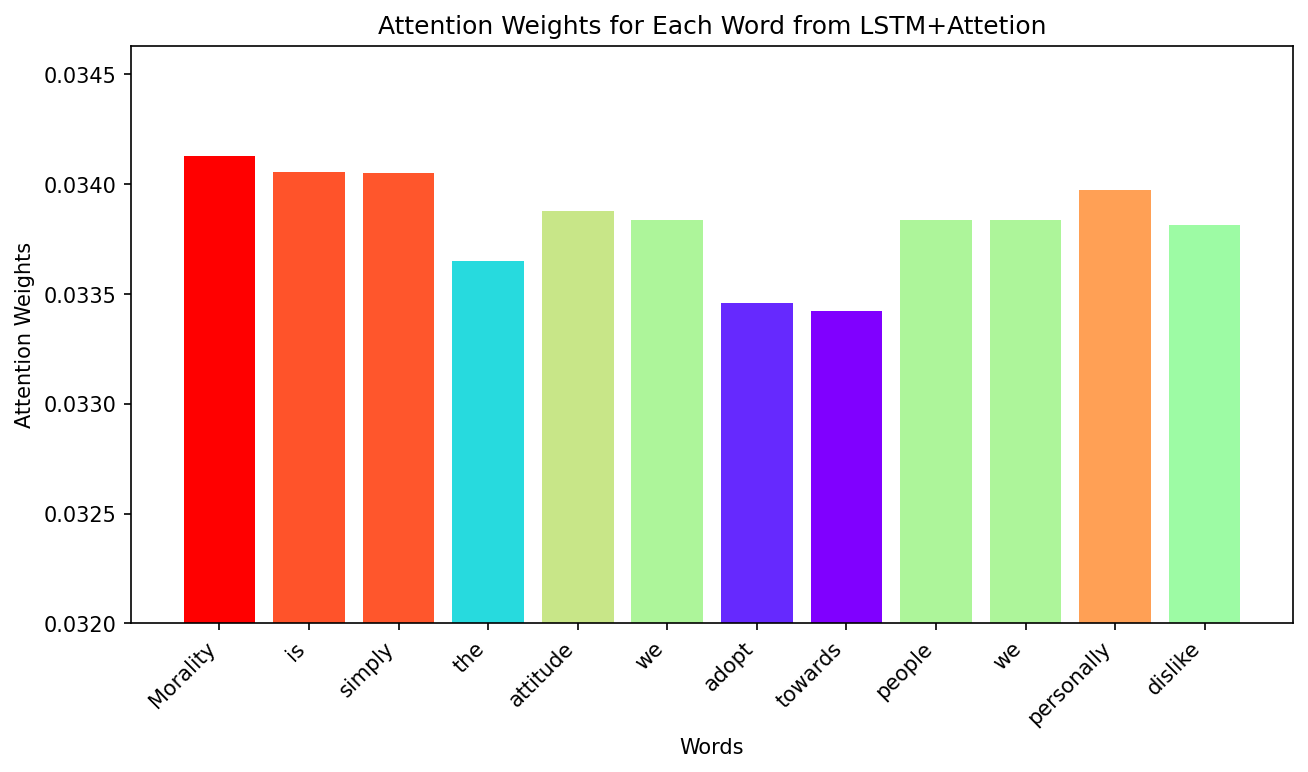

In [11]:
example_2 = "Morality is simply the attitude we adopt towards people we personally dislike"
visualize_attention_weights(example_2, attention_model, tokenizer)

1/1 [==============================] - 0s 23ms/step


[[0.00071222]]


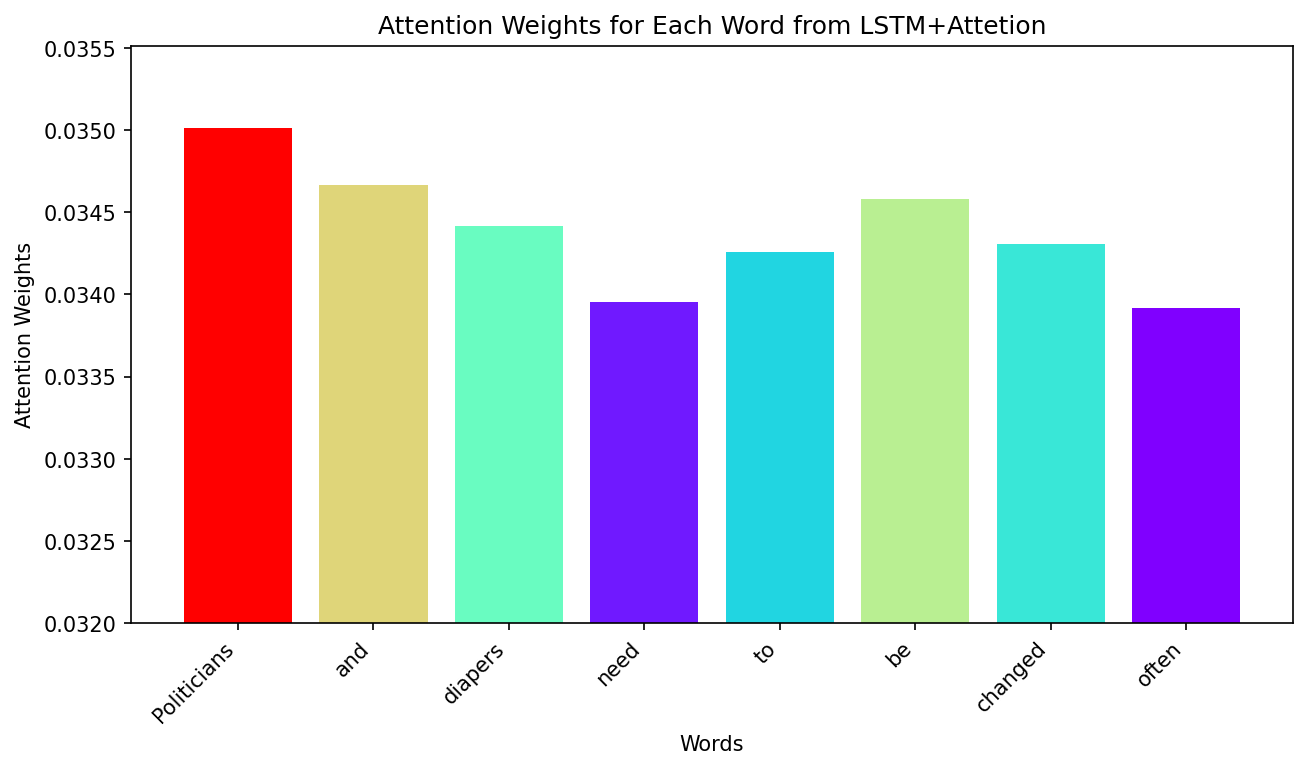

In [12]:
example_3 = "Politicians and diapers need to be changed often"
visualize_attention_weights(example_3, attention_model, tokenizer)

## Model: CNN+Bi-LSTM+Attention

In [13]:
class AttentionLayer_2(tf.keras.layers.Layer):
    """
    Keras layer to compute an attention score for each input sequence.
    """
    def __init__(self, return_attention=False, **kwargs):
        super(AttentionLayer_2, self).__init__(**kwargs)
        self.return_attention = return_attention

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(1, 1),
                                 initializer='zeros',
                                 trainable=True)
        super(AttentionLayer_2, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        if self.return_attention:
            return [K.sum(output, axis=1), a]
        return K.sum(output, axis=1)


class ConvNet(tf.keras.layers.Layer):
    def __init__(self, filter_h, out_channels):
        super(ConvNet, self).__init__()
        self.conv1d = tf.keras.layers.Conv1D(out_channels, kernel_size=filter_h,
                                             activation='relu', padding='same')

    def call(self, x):
        x = self.conv1d(x)
        return x
    
input_layer = Input(shape=(max_sequence_length_train,))
embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=100,
                            input_length=max_sequence_length_train)(input_layer)
cnn_layer = ConvNet(5, 64)(embedding_layer)
bilstm_layer = tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True))(cnn_layer)
attention_output = AttentionLayer_2(return_attention=False)(bilstm_layer)
output_layer = Dense(1, activation='sigmoid')(attention_output)

hybrid_model = Model(inputs=input_layer, outputs=output_layer)    
hybrid_model.compile(loss='binary_crossentropy', optimizer='adam',
                     metrics=['accuracy'])
hybrid_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 30, 100)           2273100   
                                                                 
 conv_net (ConvNet)          (None, 30, 64)            32064     
                                                                 
 bidirectional (Bidirection  (None, 30, 128)           66048     
 al)                                                             
                                                                 
 attention_layer_2 (Attenti  (None, 128)               129       
 onLayer_2)                                                      
                                                                 
 dense_1 (Dense)             (None, 1)                 129 

In [14]:
history_3 = hybrid_model.fit(padded_seq_train, labels_train,
                             epochs = 5,
                             validation_data = (padded_seq_test, labels_test))

Epoch 1/5
611/611 [==============================] - 24s 32ms/step - loss: 0.4098 - accuracy: 0.8070 - val_loss: 0.3253 - val_accuracy: 0.8554
Epoch 2/5
611/611 [==============================] - 19s 30ms/step - loss: 0.1625 - accuracy: 0.9394 - val_loss: 0.3588 - val_accuracy: 0.8562
Epoch 3/5
611/611 [==============================] - 18s 30ms/step - loss: 0.0568 - accuracy: 0.9808 - val_loss: 0.5186 - val_accuracy: 0.8456
Epoch 4/5
611/611 [==============================] - 18s 30ms/step - loss: 0.0238 - accuracy: 0.9925 - val_loss: 0.6364 - val_accuracy: 0.8382
Epoch 5/5
611/611 [==============================] - 18s 30ms/step - loss: 0.0104 - accuracy: 0.9968 - val_loss: 0.7495 - val_accuracy: 0.8378


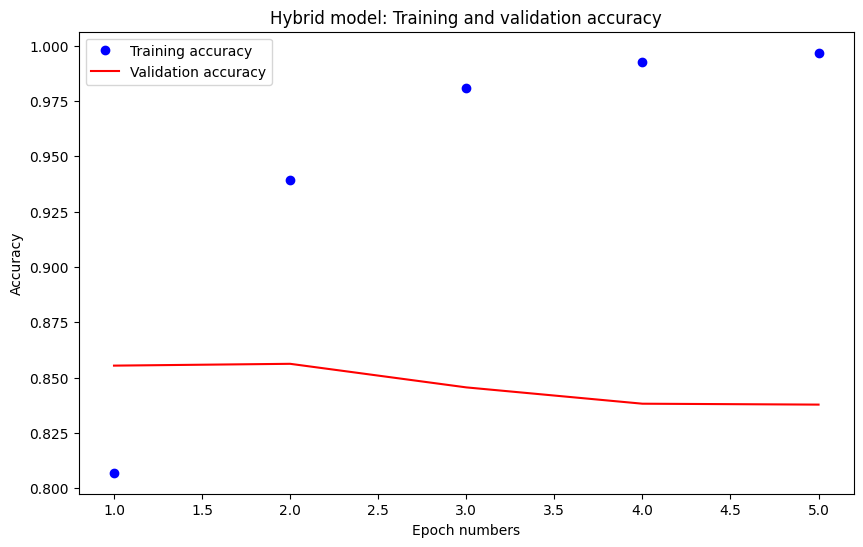

In [15]:
plt.figure(figsize=(10, 6), dpi=100)
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.legend()
plt.xlabel("Epoch numbers")
plt.ylabel("Accuracy")
plt.title('Hybrid model: Training and validation accuracy')
plt.savefig('Hybrid_acc_plot.png')
plt.show()

153/153 [==============================] - 2s 8ms/step


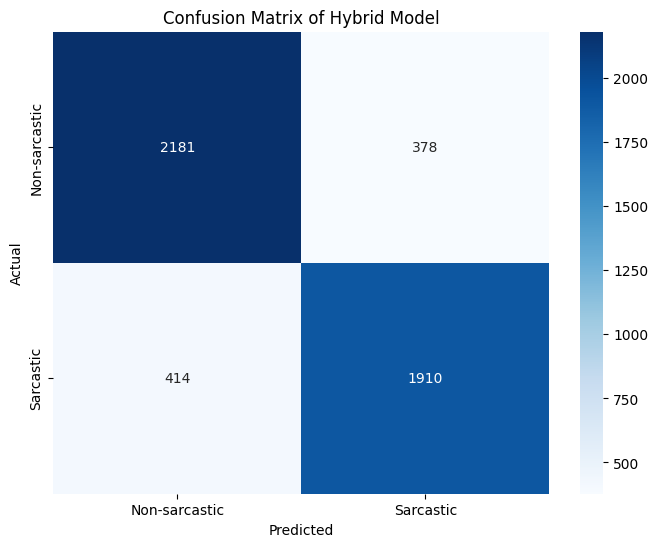

In [16]:
prob   = hybrid_model.predict(padded_seq_test)
y_pred = (prob > 0.5).astype("int32")
cm = confusion_matrix(labels_test, y_pred)

# Plotting
plt.figure(figsize=(8, 6), dpi=100)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-sarcastic', 'Sarcastic'],
            yticklabels=['Non-sarcastic', 'Sarcastic'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix of Hybrid Model')
plt.show()

1/1 [==============================] - 1s 700ms/step
[[0.9999972]]


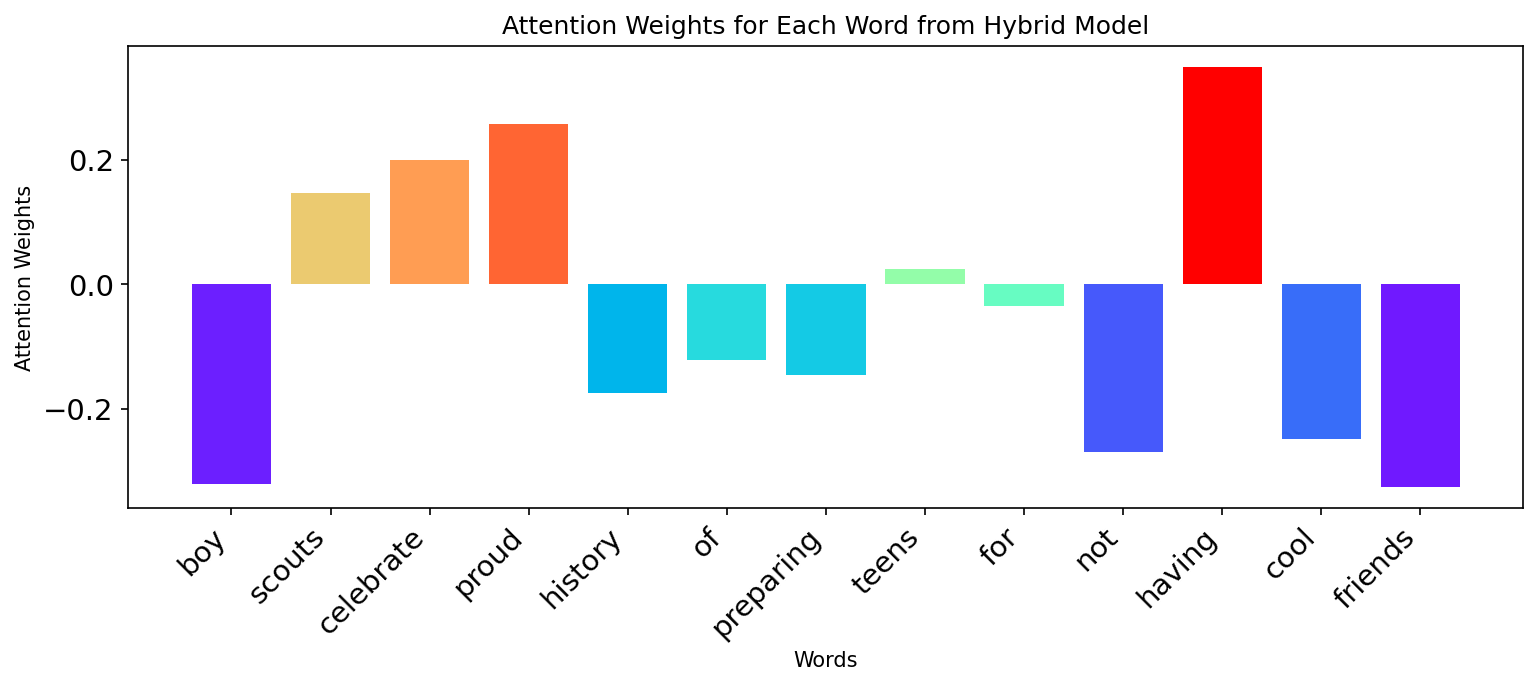

In [31]:
# import again avoiding error
from matplotlib  import cm

def visualize_attention_weights(sentence, model, tokenizer):
    # Tokenize and pad the input sentence
    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, padding="post", 
                                    maxlen=max_sequence_length_train)
    
    # Define a submodel to extract the output from attention layer with weights
    # Replace with the correct name from the summary, if u've run it many times
    attention_layer = model.get_layer('attention_layer_2')  
    submodel = Model(inputs=model.input, outputs=[model.output, attention_layer.output])
    
    # Get the prediction and attention weights
    prediction, attention_weights = submodel.predict(padded_sequence)
    print(prediction)
    
    # The attention_weights might have an extra dimension because of the batch size
    # even if it's just one sentence
    attention_weights = np.squeeze(attention_weights)
    
    # trim the weight array
    actual_length = len(sequence[0])
    trimmed_attention_weights = attention_weights[:actual_length]
    
    # Extract the words corresponding to the tokens for visualization
    words = [tokenizer.index_word.get(token) for token in sequence[0]]
    
    # Normalize the attention weights for color mapping
    max_weight = max(abs(trimmed_attention_weights.min()), trimmed_attention_weights.max())
    normalized_weights = trimmed_attention_weights / max_weight
    cols = cm.rainbow((normalized_weights + 1) / 2)
    
    # Plot the attention weights
    plt.figure(figsize=(12, 4), dpi=150)
    plt.bar(range(len(words)), trimmed_attention_weights, color=cols)
    plt.xticks(range(len(words)), words, rotation=45, ha='right')
    plt.tick_params(axis='y', which='major', labelsize=14)
    plt.tick_params(axis='x', which='major', labelsize=14)
    plt.xlabel('Words')
    plt.ylabel('Attention Weights')
    plt.title('Attention Weights for Each Word from Hybrid Model')
    plt.show()

# Example usage
visualize_attention_weights(example_1, hybrid_model, tokenizer)

1/1 [==============================] - 1s 680ms/step
[[9.2701805e-05]]


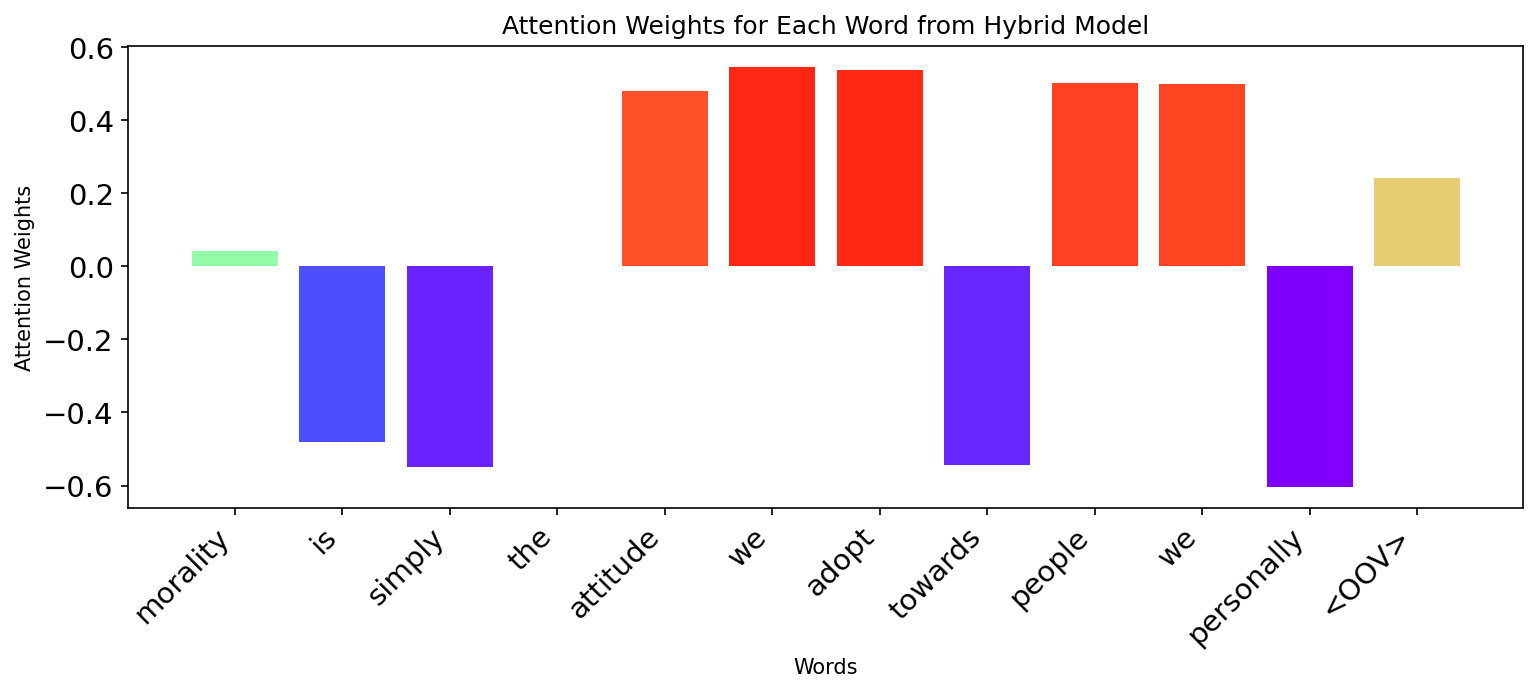

In [18]:
visualize_attention_weights(example_2, hybrid_model, tokenizer)

1/1 [==============================] - 1s 690ms/step
[[0.00083693]]


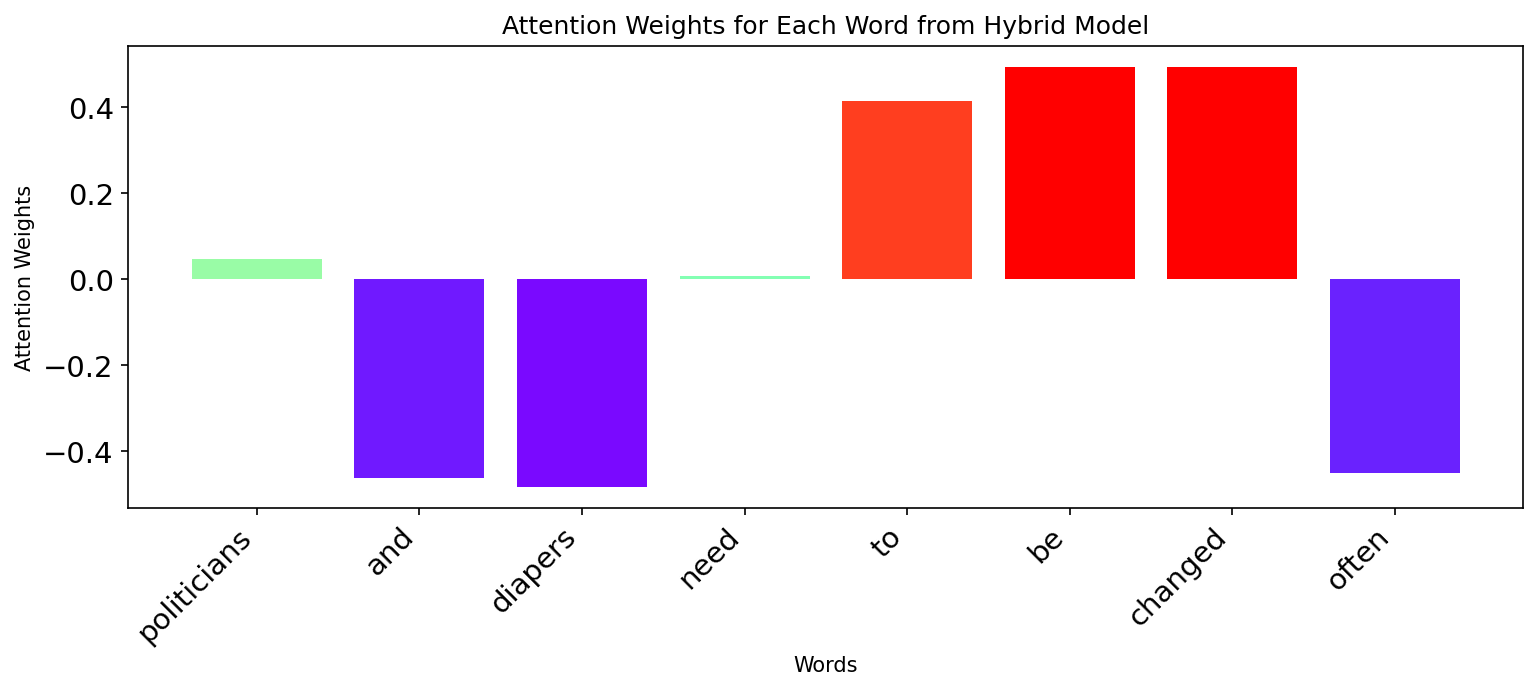

In [19]:
visualize_attention_weights(example_3, hybrid_model, tokenizer)

1/1 [==============================] - 1s 791ms/step
[[0.643344]]


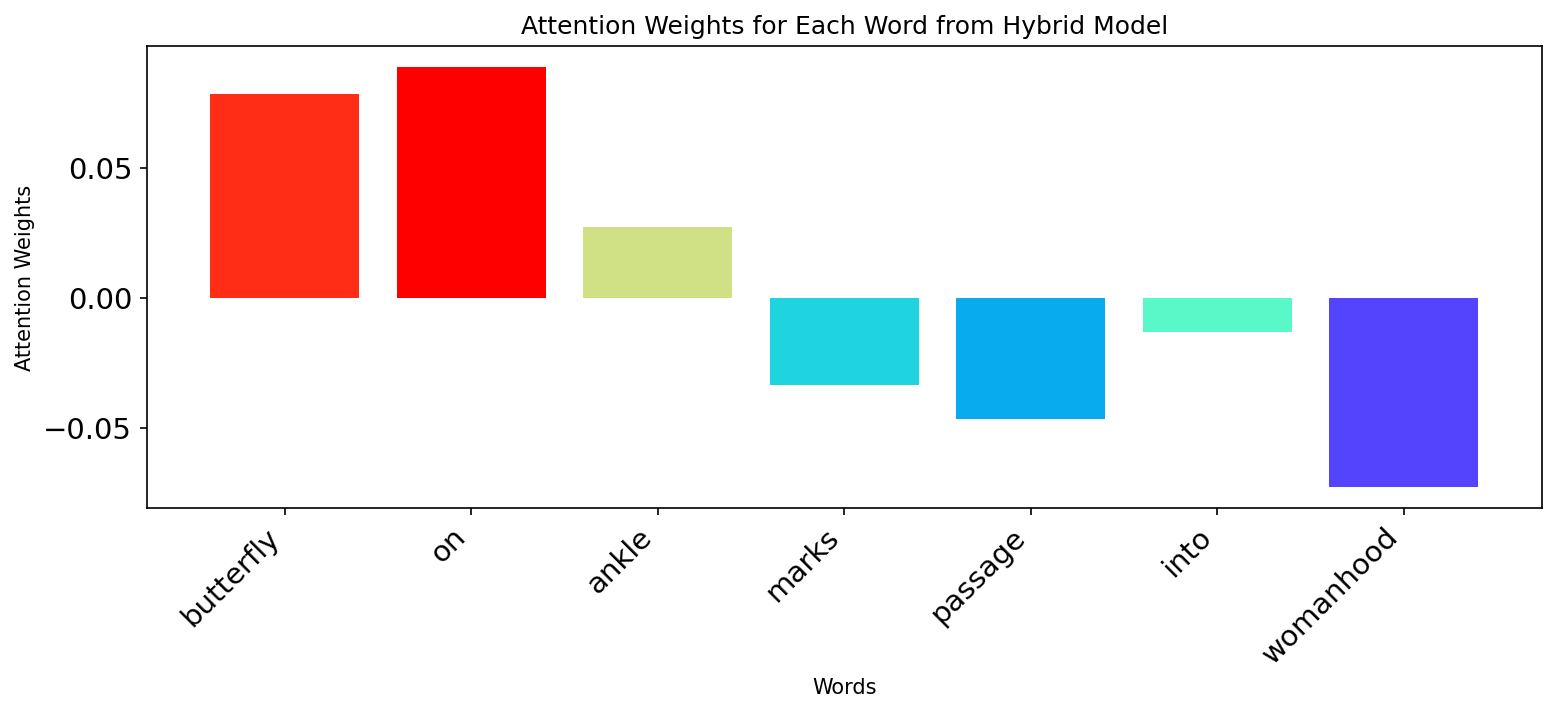

In [20]:
example_4 = "butterfly on ankle marks passage into womanhood"
visualize_attention_weights(example_4, hybrid_model, tokenizer)

1/1 [==============================] - 1s 707ms/step
[[1.]]


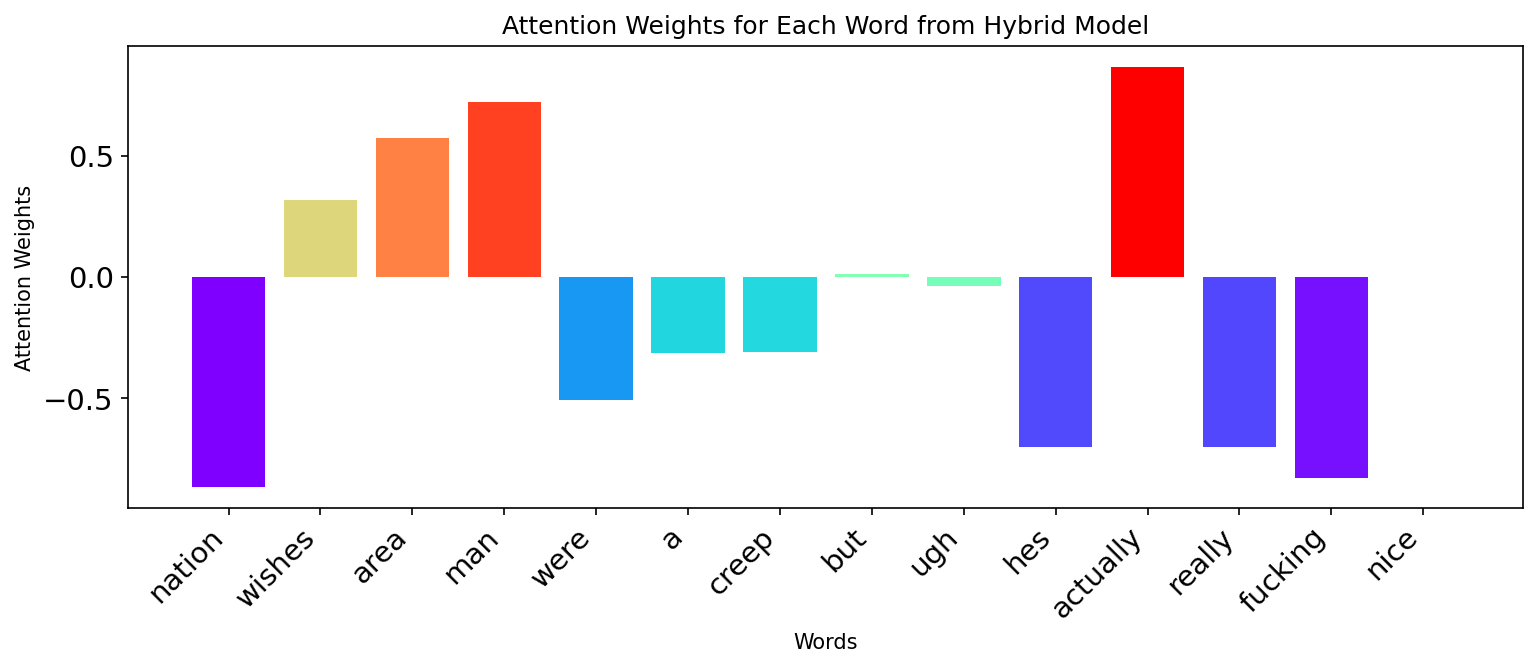

In [21]:
example_5 = "nation wishes area man were a creep but ugh hes actually really fucking nice"
visualize_attention_weights(example_5, hybrid_model, tokenizer)

1/1 [==============================] - 1s 811ms/step
[[0.99999994]]


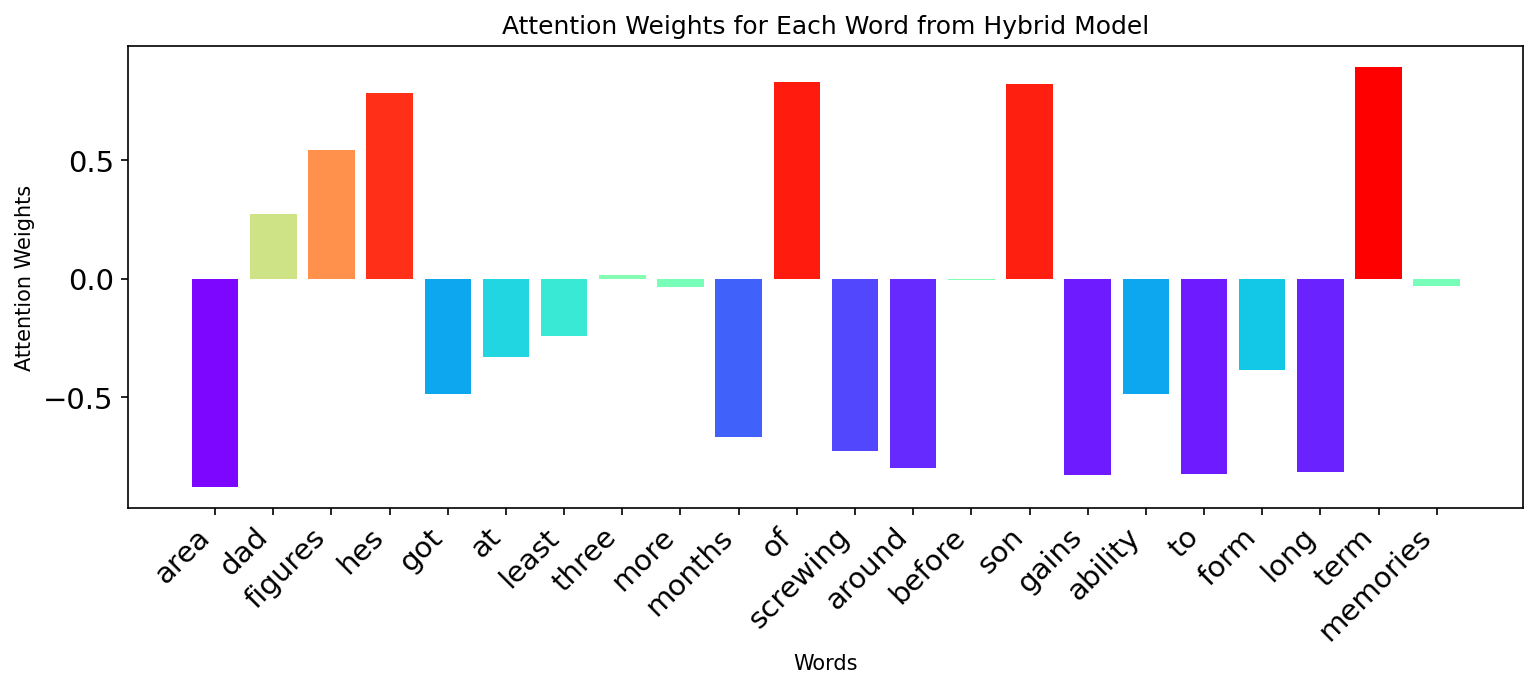

In [22]:
example_6 = "area dad figures hes got at least three more months of screwing around before son gains ability to form long term memories"
visualize_attention_weights(example_6, hybrid_model, tokenizer)

### Lime: Local Interpretable Model-agnostic Explanations

In [23]:
# Function to preprocess the text and make predictions using your model
def predict_fn_hybrid(sentences):
    seq  = tokenizer.texts_to_sequences(sentences)
    data = pad_sequences(seq, maxlen=max_sequence_length_train, padding="post")
    predictions = hybrid_model.predict(data)
    # Return probabilities for both classes
    return np.hstack((1 - predictions, predictions))

def predict_fn_attention(sentences):
    seq  = tokenizer.texts_to_sequences(sentences)
    data = pad_sequences(seq, maxlen=max_sequence_length_train, padding="post")
    pred,_ = attention_model.predict(data)
    # Return probabilities for both classes
    return np.hstack((1-pred, pred))

# Create a LimeTextExplainer
explainer = LimeTextExplainer(class_names=["Not Sarcasm", "Sarcasm"])

157/157 [==============================] - 1s 8ms/step


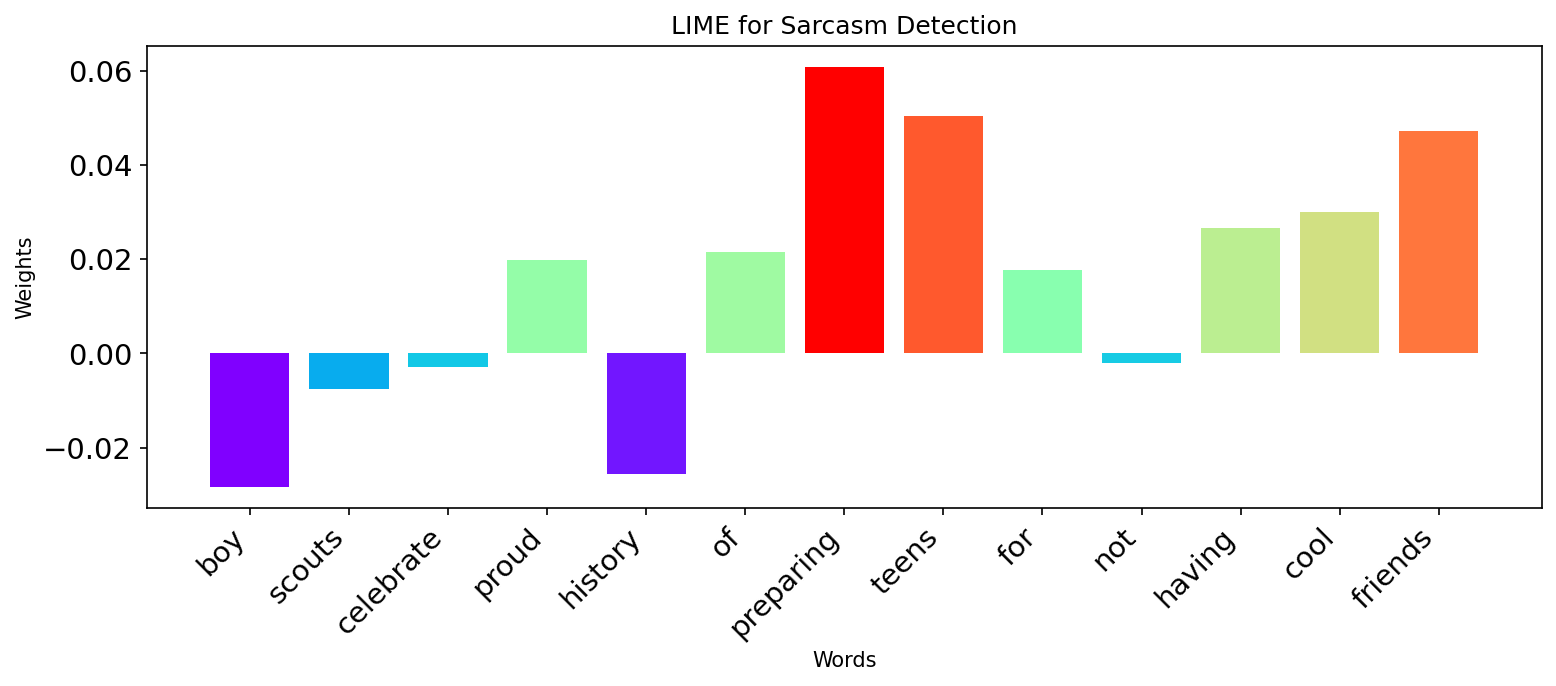

In [24]:
# Generate explanation
exp = explainer.explain_instance(example_1, predict_fn_hybrid, num_features=15)
exp_list = exp.as_list()

# Tokenize the sentence and get the word index
tokenized_sentence = tokenizer.texts_to_sequences([example_1])[0]
words = [tokenizer.index_word[token] for token in tokenized_sentence]

# Create a dictionary from the explanation list
exp_dict = dict(exp_list)

# Sort the weights by the word order in 'words'
sorted_weights = [exp_dict[word] if word in exp_dict else 0 for word in words]

# Normalize the weights for color mapping
normalized_weights = (np.array(sorted_weights) - np.min(sorted_weights)) / (np.max(sorted_weights) - np.min(sorted_weights))

# Get the corresponding colormap array for the normalized weights
cols = cm.rainbow(normalized_weights)

# Visualize the explanation
plt.figure(figsize=(12, 4), dpi=150)
plt.bar(range(len(words)), sorted_weights, color=cols)
plt.xticks(range(len(words)), words, rotation=45, ha='right')
plt.xlabel('Words')
plt.ylabel('Weights')
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.title("LIME for Sarcasm Detection")
plt.show()

 22/157 [===>..........................] - ETA: 1s

157/157 [==============================] - 1s 9ms/step


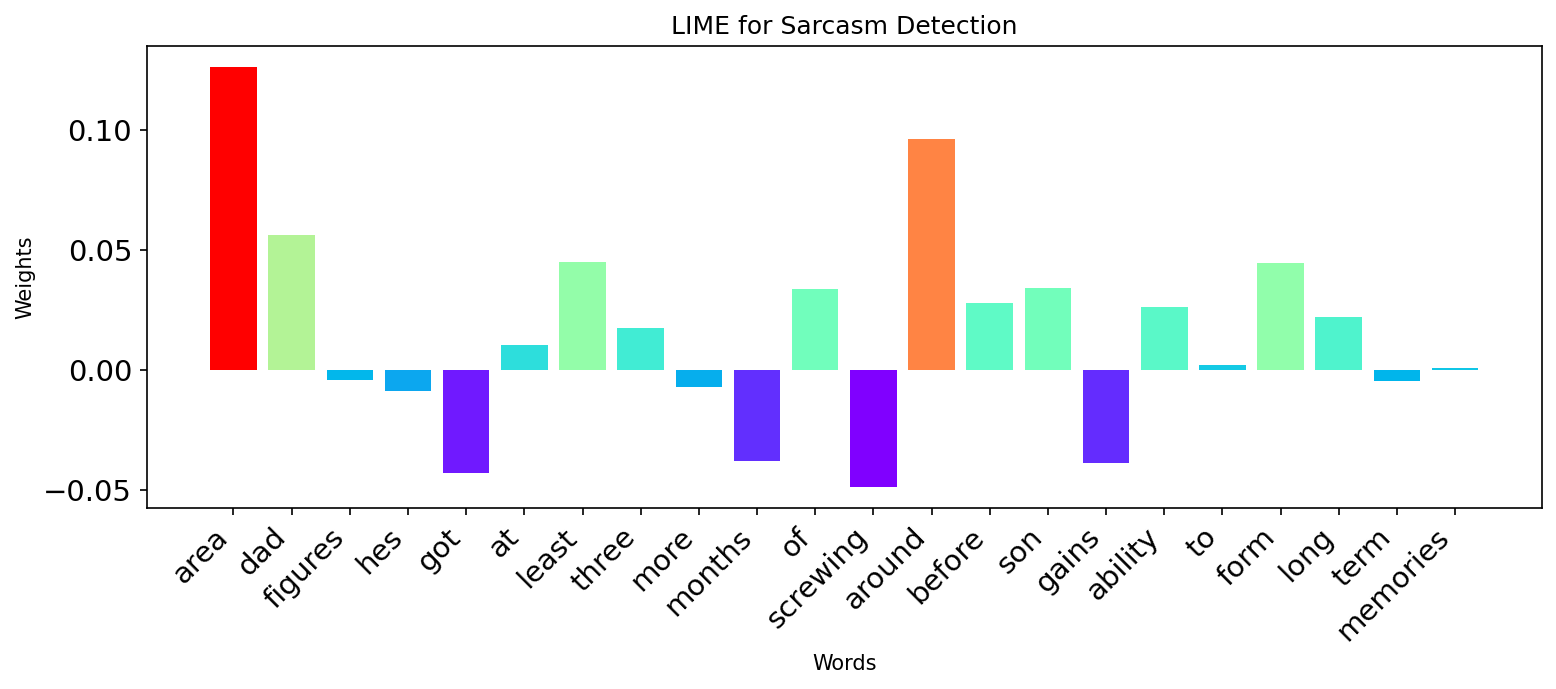

In [25]:
# Generate explanation
exp = explainer.explain_instance(example_6, predict_fn_hybrid, num_features=30)
exp_list = exp.as_list()

# Tokenize the sentence and get the word index
tokenized_sentence = tokenizer.texts_to_sequences([example_6])[0]
words = [tokenizer.index_word[token] for token in tokenized_sentence]

# Create a dictionary from the explanation list
exp_dict = dict(exp_list)

# Sort the weights by the word order in 'words'
sorted_weights = [exp_dict[word] if word in exp_dict else 0 for word in words]

# Normalize the weights for color mapping
normalized_weights = (np.array(sorted_weights) - np.min(sorted_weights)) / (np.max(sorted_weights) - np.min(sorted_weights))

# Get the corresponding colormap array for the normalized weights
cols = cm.rainbow(normalized_weights)

# Visualize the explanation
plt.figure(figsize=(12, 4), dpi=150)
plt.bar(range(len(words)), sorted_weights, color=cols)
plt.xticks(range(len(words)), words, rotation=45, ha='right')
plt.xlabel('Words')
plt.ylabel('Weights')
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.title("LIME for Sarcasm Detection")
plt.show()

157/157 [==============================] - 1s 8ms/step


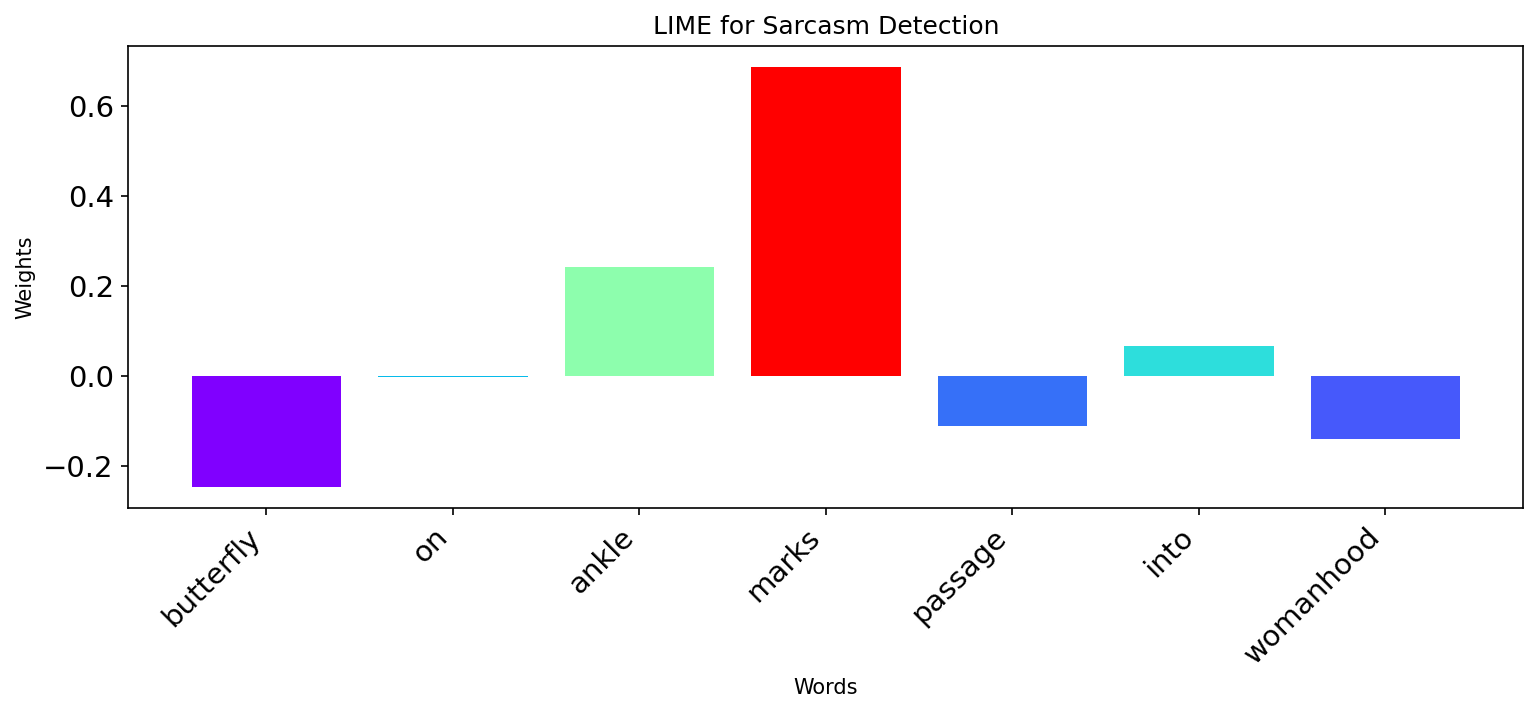

In [26]:
# Generate explanation
exp = explainer.explain_instance(example_4, predict_fn_hybrid, num_features=15)
exp_list = exp.as_list()

# Tokenize the sentence and get the word index
tokenized_sentence = tokenizer.texts_to_sequences([example_4])[0]
words = [tokenizer.index_word[token] for token in tokenized_sentence]

# Create a dictionary from the explanation list
exp_dict = dict(exp_list)

# Sort the weights by the word order in 'words'
sorted_weights = [exp_dict[word] if word in exp_dict else 0 for word in words]

# Normalize the weights for color mapping
normalized_weights = (np.array(sorted_weights) - np.min(sorted_weights)) / (np.max(sorted_weights) - np.min(sorted_weights))

# Get the corresponding colormap array for the normalized weights
cols = cm.rainbow(normalized_weights)

# Visualize the explanation
plt.figure(figsize=(12, 4), dpi=150)
plt.bar(range(len(words)), sorted_weights, color=cols)
plt.xticks(range(len(words)), words, rotation=45, ha='right')
plt.xlabel('Words')
plt.ylabel('Weights')
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.title("LIME for Sarcasm Detection")
plt.show()

157/157 [==============================] - 1s 9ms/step


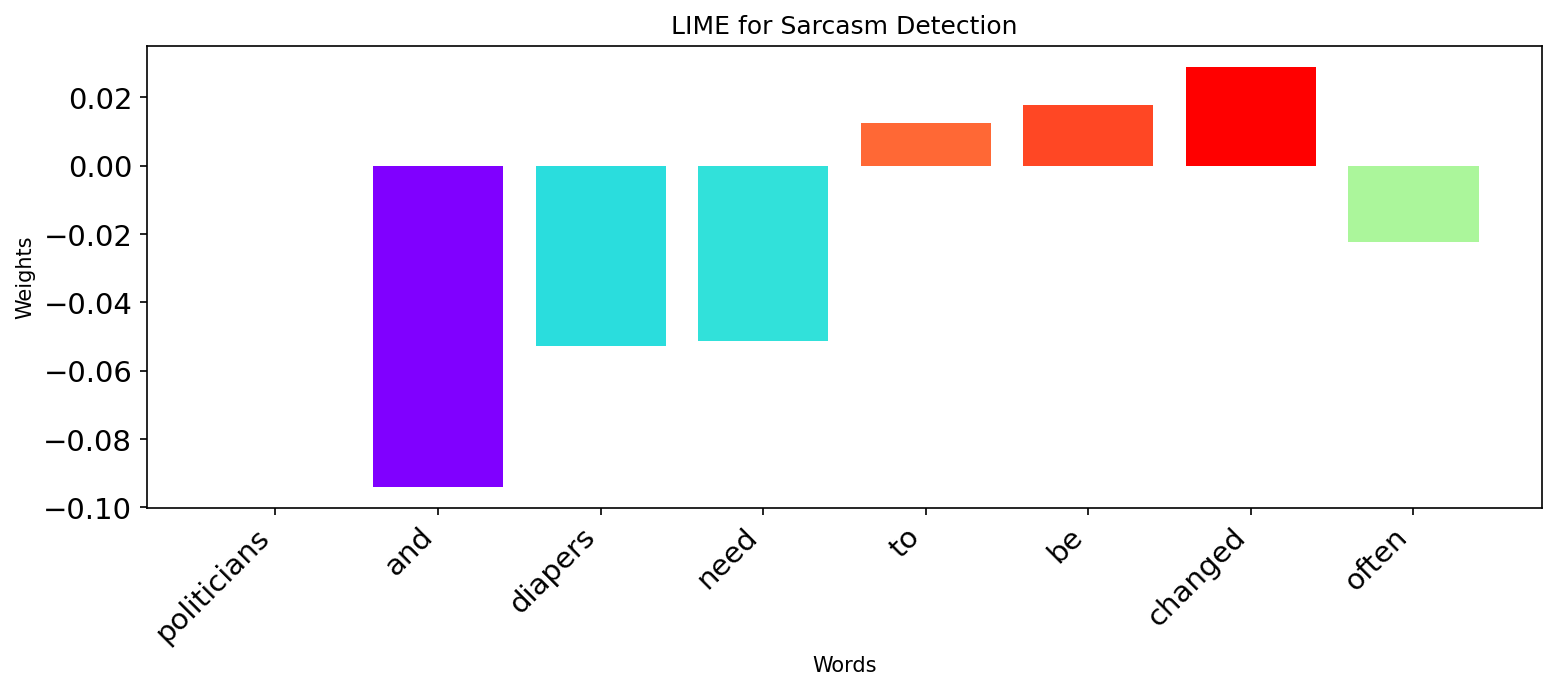

In [27]:
# Generate explanation
exp = explainer.explain_instance(example_3, predict_fn_hybrid, num_features=30)
exp_list = exp.as_list()

# Tokenize the sentence and get the word index
tokenized_sentence = tokenizer.texts_to_sequences([example_3])[0]
words = [tokenizer.index_word[token] for token in tokenized_sentence]

# Create a dictionary from the explanation list
exp_dict = dict(exp_list)

# Sort the weights by the word order in 'words'
sorted_weights = [exp_dict[word] if word in exp_dict else 0 for word in words]

# Normalize the weights for color mapping
normalized_weights = (np.array(sorted_weights) - np.min(sorted_weights)) / (np.max(sorted_weights) - np.min(sorted_weights))

# Get the corresponding colormap array for the normalized weights
cols = cm.rainbow(normalized_weights)

# Visualize the explanation
plt.figure(figsize=(12, 4), dpi=150)
plt.bar(range(len(words)), sorted_weights, color=cols)
plt.xticks(range(len(words)), words, rotation=45, ha='right')
plt.xlabel('Words')
plt.ylabel('Weights')
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.title("LIME for Sarcasm Detection")
plt.show()

### XAI Comparison

In [28]:
sequence = tokenizer.texts_to_sequences([example_1])
padded_sequence = pad_sequences(sequence, padding="post", 
                                maxlen=max_sequence_length_train)

# Define a submodel to extract the output from attention layer with weights
# Replace with the correct name from the summary, if u've run it many times
attention_layer = hybrid_model.get_layer('attention_layer_2')  
submodel = Model(inputs=hybrid_model.input, 
                 outputs=[hybrid_model.output, attention_layer.output])

# Generate explanation for both models
exp_1 = explainer.explain_instance(example_1, predict_fn_hybrid, num_features=15)
exp_2 = explainer.explain_instance(example_1, predict_fn_attention, num_features=15)
exp_list_1 = exp_1.as_list()
exp_list_2 = exp_2.as_list()

# Get the prediction and attention weights from both models
prediction_1, att_weights_1 = attention_model.predict(padded_sequence)
prediction_2, att_weights_2 = submodel.predict(padded_sequence)

# The attention_weights might have an extra dimension because of the batch size
# even if it's just one sentence
att_weights_2 = np.squeeze(att_weights_2)

# Tokenize the sentence and get the word index
tokenized_sentence = tokenizer.texts_to_sequences([example_1])[0]
words = [tokenizer.index_word[token] for token in tokenized_sentence]

# Create a dictionary from the explanation list
exp_dict_1 = dict(exp_list_1)
exp_dict_2 = dict(exp_list_2)

# Sort the weights by the word order in 'words'
sorted_weights_1 = [exp_dict_1[word] if word in exp_dict_1 else 0 for word in words]
sorted_weights_2 = [exp_dict_2[word] if word in exp_dict_2 else 0 for word in words]

# trim the weight arrays
actual_length = len(sequence[0])
trimmed_att_weights_1 = att_weights_1[0, :len(example_1.split())].reshape(-1)
trimmed_att_weights_2 = att_weights_2[:actual_length]

# Normalize the weights to [-1, 1]
def normalize_weights(weights):
    max_val = np.max(np.abs(weights))
    return weights / max_val if max_val != 0 else weights

# Normalize each set of weights
# norm_att_weights_1   = normalize_weights(trimmed_att_weights_1)
norm_att_weights_2   = normalize_weights(trimmed_att_weights_2)
norm_lime_weights_1  = normalize_weights(sorted_weights_1)
norm_lime_weights_2  = normalize_weights(sorted_weights_2)

# # Get the corresponding colormap array for the normalized weights
# cols_att_1  = cm.rainbow((normalized_weights_att_1 + 1) / 2)
cols_att_2    = cm.rainbow((norm_att_weights_2 + 1) / 2)
cols_lime_1   = cm.rainbow(norm_lime_weights_1)
# cols_lime_2   = cm.rainbow(norm_lime_weights_2)

1/1 [==============================] - 1s 669ms/step


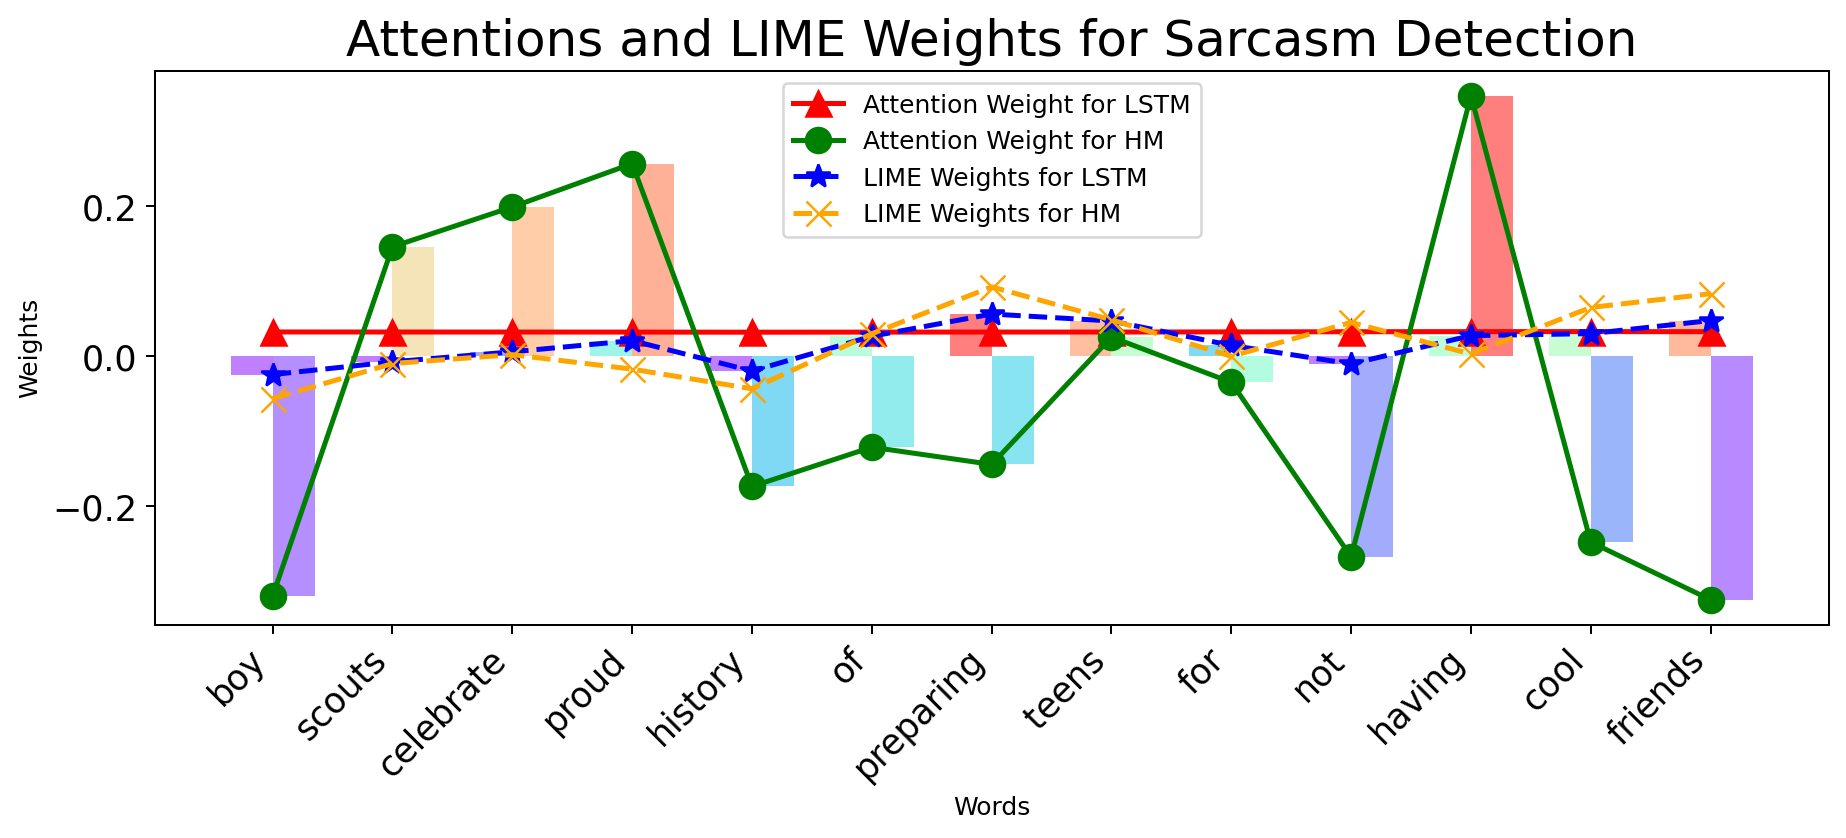

In [30]:
plt.figure(figsize=(12, 4), dpi=180)

indices   = np.arange(len(words))
bar_width = 0.35
indices_lime = indices - bar_width/2
indices_att2 = indices + bar_width/2

plt.plot(indices, trimmed_att_weights_1, color='red', 
         marker='^', linestyle='-', linewidth=2,
         markersize=10, label='Attention Weight for LSTM')
plt.plot(indices, trimmed_att_weights_2, color='green', 
         marker='o', linestyle='-', linewidth=2,
         markersize=10, label='Attention Weight for HM')
plt.plot(indices, sorted_weights_1, color='blue', 
         marker='*', linestyle='--', linewidth=2,
         markersize=10, label='LIME Weights for LSTM')
plt.plot(indices, sorted_weights_2, color='orange', 
         marker='x', linestyle='--', linewidth=2,
         markersize=10, label='LIME Weights for HM')

plt.bar(indices_att2, trimmed_att_weights_2, bar_width, color=cols_att_2, alpha=.5)
plt.bar(indices_lime, sorted_weights_1, bar_width, color=cols_lime_1, alpha=.5)

plt.xticks(indices, words, rotation=45, ha='right')
plt.xlabel('Words')
plt.ylabel('Weights')
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.title('Attentions and LIME Weights for Sarcasm Detection', size=20)
plt.legend()
plt.show()

**One outside the Dataset**

In [45]:
example_7 = "I like person better than principles and I like person with no principles better than anything else in the world"
sequence = tokenizer.texts_to_sequences([example_7])
padded_sequence = pad_sequences(sequence, padding="post", 
                                maxlen=max_sequence_length_train)

# Define a submodel to extract the output from attention layer with weights
# Replace with the correct name from the summary, if u've run it many times
attention_layer = hybrid_model.get_layer('attention_layer_2')  
submodel = Model(inputs=hybrid_model.input, 
                 outputs=[hybrid_model.output, attention_layer.output])

# Generate explanation for both models
exp_1 = explainer.explain_instance(example_7, predict_fn_hybrid, num_features=30)
exp_2 = explainer.explain_instance(example_7, predict_fn_attention, num_features=30)
exp_list_1 = exp_1.as_list()
exp_list_2 = exp_2.as_list()

# Get the prediction and attention weights from both models
prediction_1, att_weights_1 = attention_model.predict(padded_sequence)
prediction_2, att_weights_2 = submodel.predict(padded_sequence)

# The attention_weights might have an extra dimension because of the batch size
# even if it's just one sentence
att_weights_2 = np.squeeze(att_weights_2)

# Tokenize the sentence and get the word index
tokenized_sentence = tokenizer.texts_to_sequences([example_7])[0]
words = [tokenizer.index_word[token] for token in tokenized_sentence]

# Create a dictionary from the explanation list
exp_dict_1 = dict(exp_list_1)
exp_dict_2 = dict(exp_list_2)

# Sort the weights by the word order in 'words'
sorted_weights_1 = [exp_dict_1[word] if word in exp_dict_1 else 0 for word in words]
sorted_weights_2 = [exp_dict_2[word] if word in exp_dict_2 else 0 for word in words]

# trim the weight arrays
actual_length = len(sequence[0])
trimmed_att_weights_1 = att_weights_1[0, :len(example_7.split())].reshape(-1)
trimmed_att_weights_2 = att_weights_2[:actual_length]

# Normalize the weights to [-1, 1]
def normalize_weights(weights):
    max_val = np.max(np.abs(weights))
    return weights / max_val if max_val != 0 else weights

# Normalize each set of weights
# norm_att_weights_1   = normalize_weights(trimmed_att_weights_1)
norm_att_weights_2   = normalize_weights(trimmed_att_weights_2)
norm_lime_weights_1  = normalize_weights(sorted_weights_1)
norm_lime_weights_2  = normalize_weights(sorted_weights_2)

# # Get the corresponding colormap array for the normalized weights
# cols_att_1  = cm.rainbow((normalized_weights_att_1 + 1) / 2)
cols_att_2    = cm.rainbow((norm_att_weights_2 + 1) / 2)
cols_lime_1   = cm.rainbow(norm_lime_weights_1)
# cols_lime_2   = cm.rainbow(norm_lime_weights_2)

  1/157 [..............................] - ETA: 4s

1/1 [==============================] - 1s 692ms/step


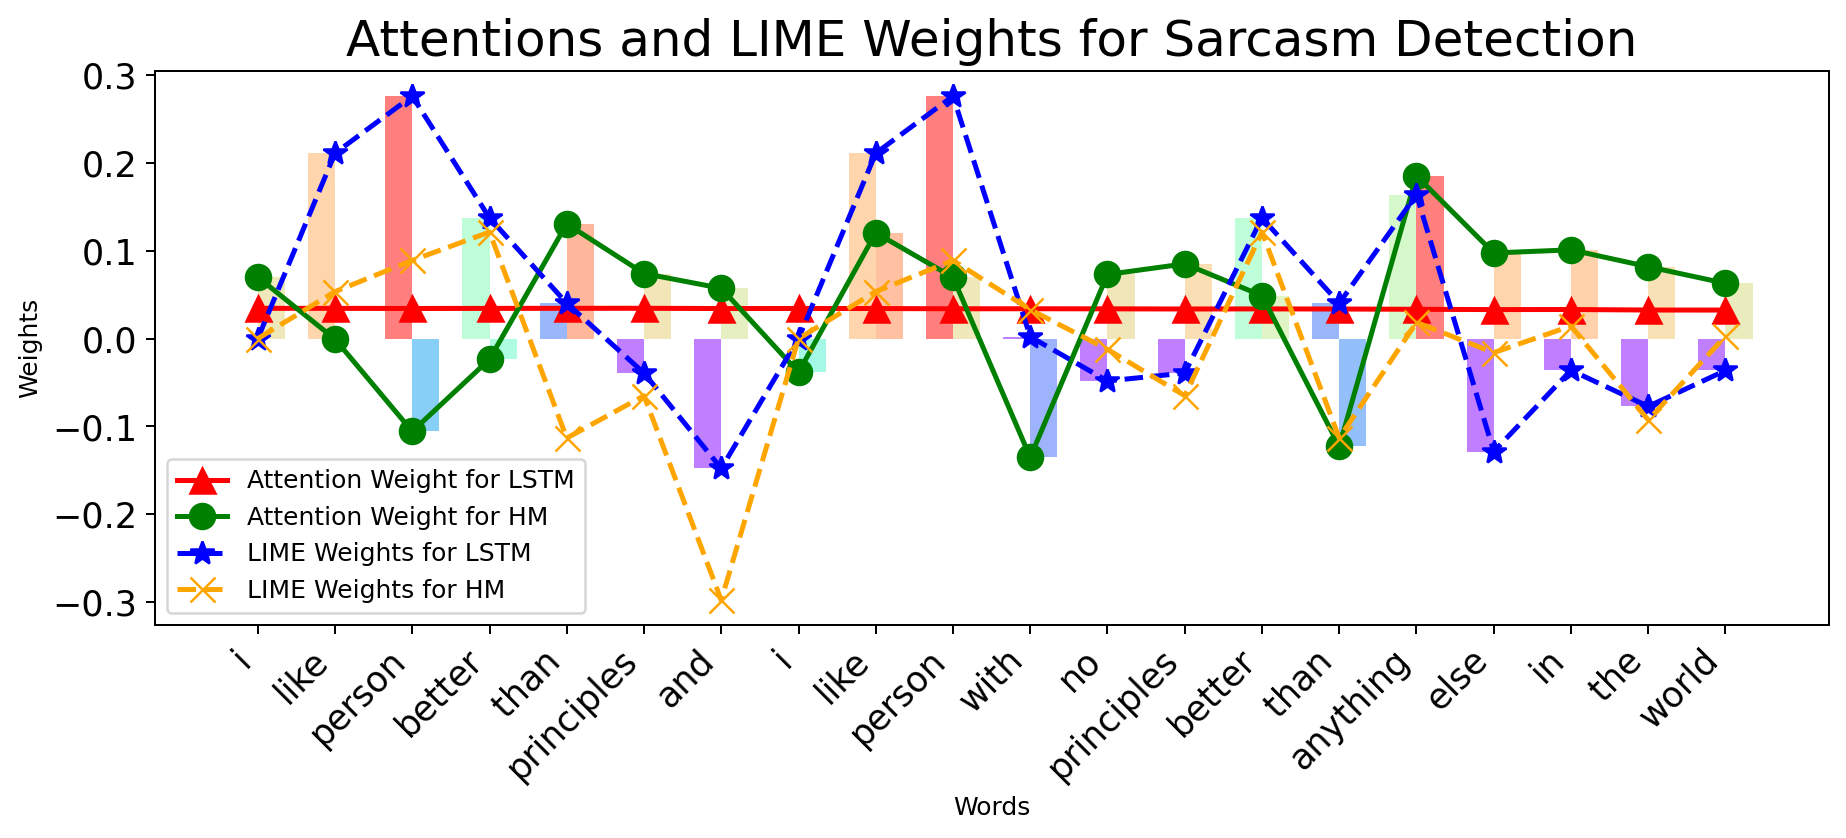

In [46]:
plt.figure(figsize=(12, 4), dpi=180)

indices   = np.arange(len(words))
bar_width = 0.35
indices_lime = indices - bar_width/2
indices_att2 = indices + bar_width/2

plt.plot(indices, trimmed_att_weights_1, color='red', 
         marker='^', linestyle='-', linewidth=2,
         markersize=10, label='Attention Weight for LSTM')
plt.plot(indices, trimmed_att_weights_2, color='green', 
         marker='o', linestyle='-', linewidth=2,
         markersize=10, label='Attention Weight for HM')
plt.plot(indices, sorted_weights_1, color='blue', 
         marker='*', linestyle='--', linewidth=2,
         markersize=10, label='LIME Weights for LSTM')
plt.plot(indices, sorted_weights_2, color='orange', 
         marker='x', linestyle='--', linewidth=2,
         markersize=10, label='LIME Weights for HM')

plt.bar(indices_att2, trimmed_att_weights_2, bar_width, color=cols_att_2, alpha=.5)
plt.bar(indices_lime, sorted_weights_1, bar_width, color=cols_lime_1, alpha=.5)

plt.xticks(indices, words, rotation=45, ha='right')
plt.xlabel('Words')
plt.ylabel('Weights')
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.title('Attentions and LIME Weights for Sarcasm Detection', size=20)
plt.legend()
plt.show()

## Model: Transformer

## Plotting all 4 performance together 
**with epoch would be ideal**